In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
import glob
import os
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, KFold, GroupKFold,RepeatedStratifiedKFold, StratifiedKFold
from mlxtend.classifier import StackingCVClassifier, StackingClassifier
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import warnings
import pydot
warnings.filterwarnings('ignore')

In [3]:
#Function to load data for each participant
def load_data(entry,activity):
    path = r'C:/Users/vijay/Documents/Thesis_Data/NewData/data/'+entry+'/'+activity                     # use your path
    all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
    df_from_each_file = (pd.read_csv(f).iloc[1:270001] for f in all_files)
    concatenated_df   = np.column_stack((df_from_each_file))
    return concatenated_df 

In [4]:
#Function to compile data for each participant
def compile_data(entry):
    asm = load_data(entry,'ASM')
    mmh = load_data(entry,'MMH')  
    psi = load_data(entry,'PSI')
    asm = np.delete(asm,[0,3,6,9],1)
    mmh = np.delete(mmh,[0,3,6,9],1)
    psi = np.delete(psi,[0,3,6,9],1)
    data = np.concatenate([asm,mmh,psi],axis=0)
    return data

#Function to compile data for first and fifth participant as they do not have PSI activity
def compile_one_five(entry):
    asm = load_data(entry,'ASM')
    mmh = load_data(entry,'MMH')  
    asm = np.delete(asm,[0,3,6,9],1)
    mmh = np.delete(mmh,[0,3,6,9],1)  
    data = np.concatenate([asm,mmh],axis=0)
    return data

In [5]:
#Compiling sensors data
p1_data = compile_one_five('P1')
p2_data = compile_data('P2')
p3_data = compile_data('P3')
p4_data = compile_data('P4')
p5_data = compile_one_five('P5')
p6_data = compile_data('P6')
p7_data = compile_data('P7')
p8_data = compile_data('P8')
print("Shape of:\nP1 :{}\np2: {}\np3 : {}\np4 : {}\np5 : {}\np6 : {}\np7 : {}\np8 : {}".format(p1_data.shape,p2_data.shape,p3_data.shape,p4_data.shape,p5_data.shape,p6_data.shape,p7_data.shape,p8_data.shape))

Shape of:
P1 :(540000, 8)
p2: (810000, 8)
p3 : (810000, 8)
p4 : (810000, 8)
p5 : (540000, 8)
p6 : (810000, 8)
p7 : (810000, 8)
p8 : (810000, 8)


In [6]:
#Function to load data (First ASM, MMH, and PSI)
def load_RPE(entry):
    path = r'C:/Users/vijay/Documents/Thesis_Data/NewData/data/RPE/'+entry                    # use your path
    all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
    df_from_each_file = (pd.read_csv(f) for f in all_files)
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    return concatenated_df

In [7]:
#Loading RPE data for each participant
p1_RPE = load_RPE('P1').values
p2_RPE = load_RPE('P2').values
p3_RPE = load_RPE('P3').values
p4_RPE = load_RPE('P4').values
p5_RPE = load_RPE('P5').values
p6_RPE = load_RPE('P6').values
p7_RPE = load_RPE('P7').values
p8_RPE = load_RPE('P8').values
print("Shape of:\nP1 :{}\np2: {}\np3 : {}\np4 : {}\np5 : {}\np6 : {}\np7 : {}\np8 : {}".format(p1_RPE.shape,p2_RPE.shape,p3_RPE.shape,p4_RPE.shape,p5_RPE.shape,p6_RPE.shape,p7_RPE.shape,p8_RPE.shape))

Shape of:
P1 :(36, 2)
p2: (54, 2)
p3 : (54, 2)
p4 : (54, 2)
p5 : (36, 2)
p6 : (54, 2)
p7 : (54, 2)
p8 : (54, 2)


In [8]:
compiled_data_part = np.concatenate([p1_data,p2_data, p3_data,p4_data,p5_data,p6_data,p7_data,p8_data],axis=0)
print("Compiled data shape:{}".format(compiled_data_part.shape))

Compiled data shape:(5940000, 8)


In [9]:
#Compiling RPE data
compiled_rpe_part = np.concatenate([p1_RPE[:,1],p2_RPE[:,1],p3_RPE[:,1],p4_RPE[:,1],p5_RPE[:,1],p6_RPE[:,1],p7_RPE[:,1],p8_RPE[:,1]],axis=0)
print("Compiled RPE shape:{}".format(compiled_rpe_part.shape))

Compiled RPE shape:(396,)


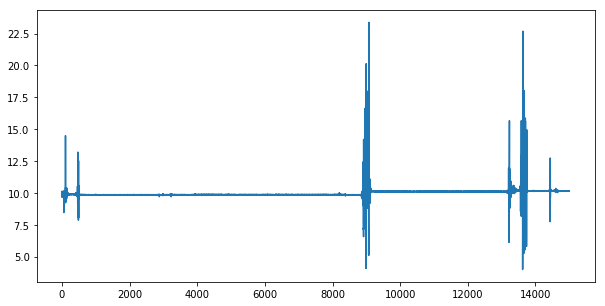

In [10]:
plt.figure(figsize=(10,5))
plt.plot(compiled_data_part[:15000,0])
plt.show()

In [11]:
def integration_function(data,tsteps):
    velocity = [0]
    time = tsteps
    for acc in data:
        velocity.append(velocity[-1] + acc * time)
    del velocity[0]
    return velocity

def integrate_data(data,n,tsteps):
    splits = np.vsplit(data,n)
    com_velocity = []
    time_steps = tsteps    
    
    for j in range(0,int(data.shape[1])):
        for i in range(0,len(splits)):
            array = splits[i][:,j]       
            vel = integration_function(array,time_steps)        
            com_velocity.append(vel)
    
    new_values = np.column_stack([com_velocity])
    new_values = np.swapaxes(new_values,1,0)
    final_data = new_values.reshape((int(data.shape[0]),int(data.shape[1])),order="F")
    
    return final_data

In [12]:
first_integration = integrate_data(compiled_data_part[:],22,0.04)
#second_integration = integrate_data(first_integration,8,0.04)
first_integration.shape

(5940000, 8)

**Denoising data - Frequency domain**

In [13]:
from scipy import fftpack #import fft, ifft
def fft_dct(data,n,index):
    splits = np.vsplit(data,n)
    values = []
    
    for j in range(0,int(data.shape[1])):
        for i in range(len(splits)):
            array = splits[i][:,j]
            dct = fftpack.dct(array,norm="ortho")
            dct[index:]=0
            smoothed = fftpack.idct(dct,norm="ortho")
            
            values.append(smoothed)
    
    new_values = np.column_stack(values)
    final_data = new_values.reshape((int(data.shape[0]),int(data.shape[1])),order="F")
    
    return final_data

In [14]:
#Low-pass filt
trend_smooth = fft_dct(compiled_data_part[:],22,50)
trend_smooth.shape

(5940000, 8)

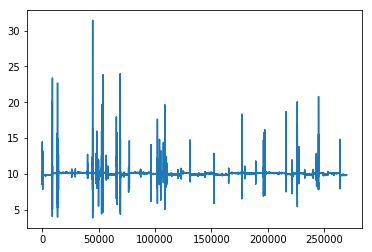

In [15]:
#Original signal
plt.plot(compiled_data_part[:270000,0])

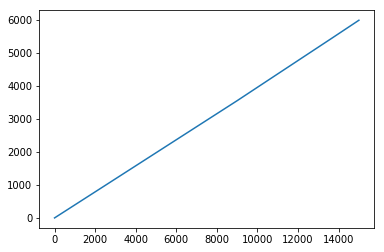

In [16]:
#Filtered signal
plt.plot(first_integration[:15000,0])
plt.show()

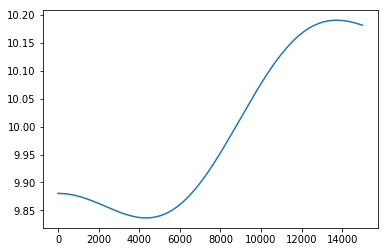

In [17]:
#Filtered signal
plt.plot(trend_smooth[:15000,0])
plt.show()

In [18]:
#Function to downsample signal using simple mean
def simple_mean(data):
    data_df = pd.DataFrame(data)
    mean = data_df.groupby(data_df.index//1500).mean().values    
    return mean

In [66]:
#Downsampling filtered signal
downsampled_fft = simple_mean(trend_smooth)
downsampled_integ = simple_mean(first_integration)
downsampled_data = np.column_stack([downsampled_fft,downsampled_integ])
downsampled_fft.shape,downsampled_integ.shape,downsampled_data.shape

((3960, 8), (3960, 8), (3960, 16))

In [21]:
asm = np.tile(0,180)
mmh = np.tile(1,180)
psi = np.tile(2,180)
p1 = np.concatenate([asm,mmh],axis=0)
p2 = np.concatenate([asm,mmh,psi],axis=0)
p3 = np.concatenate([asm,mmh,psi],axis=0)
p4 = np.concatenate([asm,mmh,psi],axis=0)
p5 = np.concatenate([asm,mmh],axis=0)
p6 = np.concatenate([asm,mmh,psi],axis=0)
p7 = np.concatenate([asm,mmh,psi],axis=0)
p8 = np.concatenate([asm,mmh,psi],axis=0)

activity = np.concatenate([p1,p2,p3,p4,p5,p6,p7,p8],axis=0)
activity.shape

(3960,)

In [24]:
#Preparing dataframes with coulumn names and labels for analysis
cols = ['acc_ankle_mn','jerk_ankle_mn','acc_chest_mn','jerk_chest_mn','acc_hip_mn','jerk_hip_mn','acc_wrist_mn','jerk_wrist_mn']

idx = np.tile(np.arange(1,181,1),22)# ,8 for MMH and ASM
#cum_trend_ds_df = pd.DataFrame(cum_trend_ds[:,:8],columns=cols, index = idx)
ds_signal_df = pd.DataFrame(downsampled_fft,columns=cols)
#cum_trend_ds_df['labels'] = compiled_rpe.astype(int).copy()
#cum_trend_ds_df['activity'] = activity
ds_signal_df['activity'] = activity
#ds_signal_df['time'] = idx.copy()
#ds_signal_df['labels'] = labels.astype(int).copy()

In [26]:
activity_mean = ds_signal_df.iloc[:,:].groupby(['activity']).mean()
activity_mean

,acc_ankle_mn,jerk_ankle_mn,acc_chest_mn,jerk_chest_mn,acc_hip_mn,jerk_hip_mn,acc_wrist_mn,jerk_wrist_mn
activity,,,,,,,,
0,10.020052,4.361139,9.869303,4.140274,9.880493,4.229863,9.958924,23.300110
1,12.918540,139.427283,10.027471,52.806794,10.169044,79.146367,10.199606,58.560187
2,10.712312,37.427616,9.843212,19.145700,9.839557,23.915429,10.322439,51.750235


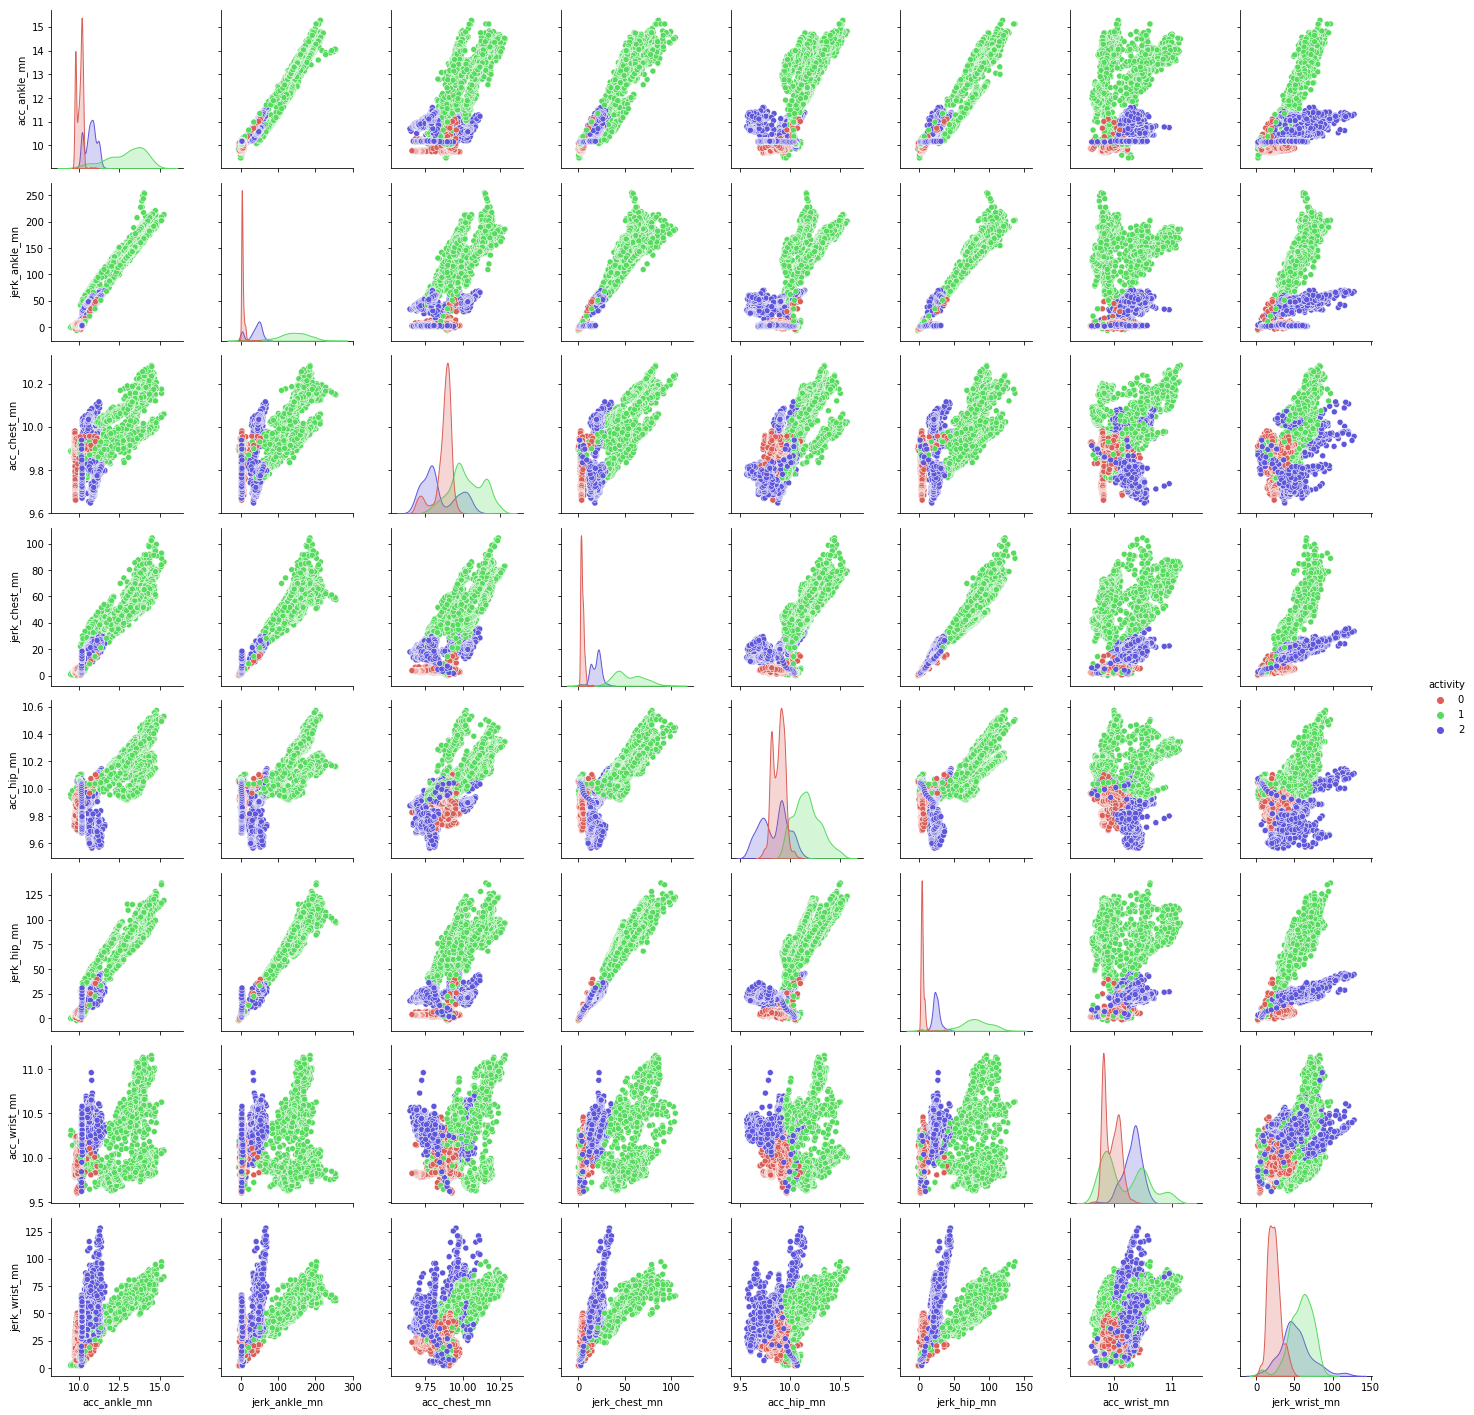

In [97]:
#Scatter plot based on labels
cmap = sns.color_palette("hls", len(np.unique(activity)))
sns.pairplot(ds_signal_df,hue = "activity",palette=cmap)
plt.show()

In [75]:
#Downsampled splits
X_train = downsampled_data[:3240].copy()
X_test = downsampled_data[3240:].copy()
Y_train = activity[:3240].copy()
Y_test = activity[3240:].copy()
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3240, 16), (720, 16), (3240,), (720,))

In [76]:
#Best models
lr = LinearSVC(random_state=0, tol=0.0001,C=1)
lrr = LogisticRegression(penalty='l2',max_iter=200,C=1)
sv_rbf = SVC(kernel = 'rbf',gamma=0.01,C=1,random_state=1)
sv_lr = SVC(kernel = 'linear',gamma=0.01,C=1,random_state=1)
gb = GaussianNB()
sgd = SGDClassifier(alpha=0.01,penalty='l2',shuffle=False,random_state=3)
knn = KNeighborsClassifier(n_neighbors=47,weights='distance')
rfc = RandomForestClassifier(n_estimators=30, max_depth = 5, random_state=1)
abc = AdaBoostClassifier(n_estimators=300, random_state=2, learning_rate=0.0001)
gbc = GradientBoostingClassifier(n_estimators=20,learning_rate=0.001,max_depth=3,random_state=3)
mlp = MLPClassifier(random_state=1, max_iter= 20)
lda = LinearDiscriminantAnalysis()

In [77]:
cv = KFold(n_splits=18, shuffle=False)
cv

KFold(n_splits=18, random_state=None, shuffle=False)

In [33]:
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
transformer = RobustScaler()
rus = RandomOverSampler(random_state=1)

In [89]:
sclf = StackingCVClassifier(classifiers=[lr,lrr,lda], meta_classifier=sv_lr,cv=cv)
clf = make_pipeline(rus,RobustScaler(),lda)
clf.fit(X_train,Y_train)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=1)),
                ('robustscaler', RobustScaler()),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [90]:
pred_train = np.round(clf.predict(X_train))

In [91]:
print(confusion_matrix(Y_train,pred_train))
print(classification_report(Y_train,pred_train))

[[1257    0    3]
 [  29 1220   11]
 [   9    0  711]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1260
           1       1.00      0.97      0.98      1260
           2       0.98      0.99      0.98       720

    accuracy                           0.98      3240
   macro avg       0.98      0.98      0.98      3240
weighted avg       0.98      0.98      0.98      3240



In [92]:
pred_test = np.round(clf.predict(X_test))

In [93]:
print(confusion_matrix(Y_test,pred_test))
print(classification_report(Y_test,pred_test))

[[180   0   0]
 [ 12 165   3]
 [ 22   0 338]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       180
           1       1.00      0.92      0.96       180
           2       0.99      0.94      0.96       360

    accuracy                           0.95       720
   macro avg       0.94      0.95      0.94       720
weighted avg       0.96      0.95      0.95       720



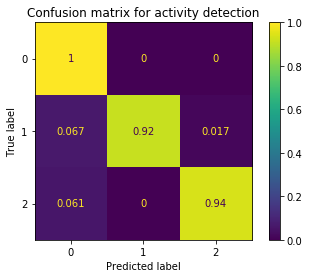

In [94]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, Y_test,normalize='true')
plt.title('Confusion matrix for activity detection')
plt.show()

In [95]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(10, 5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

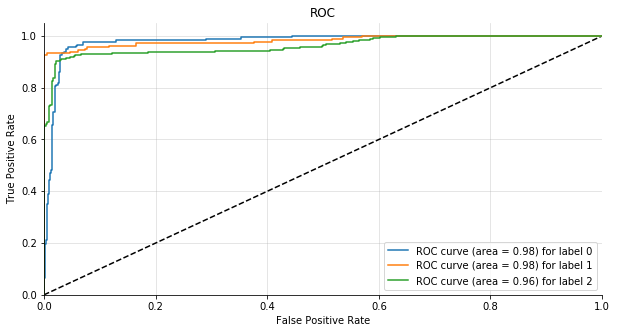

In [96]:
plot_multiclass_roc(clf,X_test,Y_test,3,figsize=(10, 5))

In [39]:
from sklearn.metrics import make_scorer, mean_absolute_error
train_mae = mean_absolute_error(Y_train,pred_train)
test_mae = mean_absolute_error(Y_test,pred_test)
print("Train MAE:{}\nTest MAE:{}\n".format(train_mae,test_mae))

Train MAE:0.019753086419753086
Test MAE:0.08194444444444444



In [87]:
import pickle
pickle.dump(clf, open('activity_model.sav', 'wb'))
loaded_model = pickle.load(open('activity_model.sav', 'rb'))